In [1]:
# Import Base Python Libraries used in this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from datetime import datetime, timedelta
from numpy import array
from numpy import split
from math import sqrt

# Import Libraries for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Import Libraries for classic AI Model
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from skforecast.model_selection import grid_search_forecaster

# Import LSTM libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM

# Turn off Warnings
warnings.filterwarnings("ignore")

In [2]:
# Load Dataset
home_df = pd.read_csv('HomeC.csv')

# Drop last row which has bad data
home_df = home_df[:len(home_df)-1]

# Rename column to make it easier to work with
home_df.rename(columns={'Solar [kW]': 'Solar', }, inplace=True)

# Create a DateTime column from the current Unix time column
home_df['Datetime'] = pd.to_datetime(home_df['time'], unit='s', errors='coerce') - timedelta(hours=5)
home_df['Datetime'] = pd.date_range(start=home_df['Datetime'].min(), periods=len(home_df), freq='min')

# Backfill cloudCover data that is incorrectly filled with 'cloudCover'
home_df['cloudCover'].replace(['cloudCover'], method='bfill', inplace=True) 
home_df['cloudCover'] = home_df['cloudCover'].astype('float') 
home_df.head()

,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,Datetime
0,1451624400,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,...,Clear,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,2016-01-01 00:00:00
1,1451624401,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,...,Clear,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,2016-01-01 00:01:00
2,1451624402,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,...,Clear,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,2016-01-01 00:02:00
3,1451624403,1.022050,0.003483,1.022050,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,...,Clear,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,2016-01-01 00:03:00
4,1451624404,1.139400,0.003467,1.139400,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,...,Clear,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,2016-01-01 00:04:00


In [3]:
# Select key columns for modeling based on previous data exploration
features = ['time', 'Datetime', 'Solar', 'temperature', 'visibility', 'cloudCover', 'windSpeed', 'humidity']
solar_df = home_df[features]

# Output Solar Dataframe
solar_df.head()


,time,Datetime,Solar,temperature,visibility,cloudCover,windSpeed,humidity
0,1451624400,2016-01-01 00:00:00,0.003483,36.14,10.0,0.75,9.18,0.62
1,1451624401,2016-01-01 00:01:00,0.003467,36.14,10.0,0.75,9.18,0.62
2,1451624402,2016-01-01 00:02:00,0.003467,36.14,10.0,0.75,9.18,0.62
3,1451624403,2016-01-01 00:03:00,0.003483,36.14,10.0,0.75,9.18,0.62
4,1451624404,2016-01-01 00:04:00,0.003467,36.14,10.0,0.75,9.18,0.62


In [4]:
hour_df = solar_df.groupby('Datetime')['Solar', 'temperature', 'visibility'].sum()
hour_df = hour_df.groupby(pd.Grouper(freq='60Min', label='right')).sum()
hour_df

,Solar,temperature,visibility
Datetime,,,
2016-01-01 01:00:00,0.198417,2167.86,600.00
2016-01-01 02:00:00,0.205300,2150.32,600.00
2016-01-01 03:00:00,0.206900,2123.10,600.00
2016-01-01 04:00:00,0.206850,2116.92,600.00
2016-01-01 05:00:00,0.206350,2127.10,600.00
...,...,...,...
2016-12-15 19:00:00,0.248250,2219.40,562.80
2016-12-15 20:00:00,0.246533,2255.05,531.32
2016-12-15 21:00:00,0.248483,2185.76,514.58


# Random Forest Regression Model

Train dates : 2016-01-01 01:00:00 --- 2016-09-19 11:00:00  (n=6299)
Test dates  : 2016-09-19 12:00:00 --- 2016-12-15 23:00:00  (n=2100)


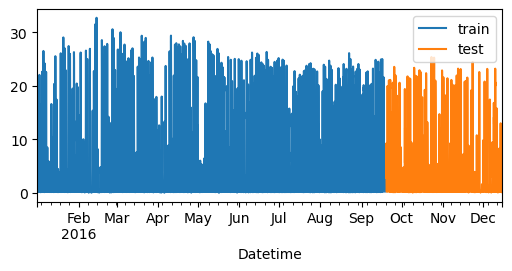

In [5]:
# Split data into 75% Training and 25% Testing
steps = round(len(hour_df) * .25)
data_train = hour_df[:-steps]
data_test = hour_df[-steps:]

# Check dataset lengths
print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

# Plot Datasets to vizualize and confirm split
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['Solar'].plot(ax=ax, label='train')
data_test['Solar'].plot(ax=ax, label='test')
ax.legend();

In [6]:
# Use SK Forecaster to perform multi-step forecasting
#  https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 12  # Previous hours of data to consider in model
             )

forecaster.fit(y=data_train['Solar'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: None 
Transformer for exog: None 
Window size: 12 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2016-01-01 01:00:00'), Timestamp('2016-09-19 11:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: 60T 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-02-16 05:20:34 
Last fit date: 2024-02-16 05:20:44 
Skforecast version

Test error (MSE): 2.758874391187448


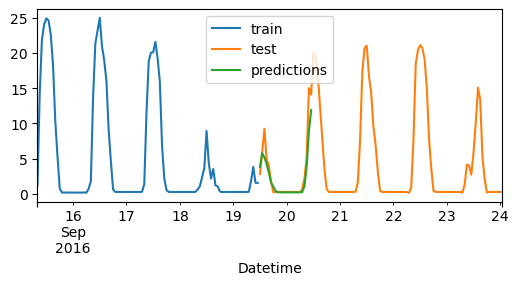

In [7]:
# Predict 24 Hours into the future
steps = 24
predictions = forecaster.predict(steps=steps)

# Plot predictions versus test data
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['Solar'][-100:].plot(ax=ax, label='train')
data_test['Solar'][:110].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Calculate MSE
error_mse = mean_squared_error(
                y_true = data_test['Solar'][:steps],
                y_pred = predictions
            )

print(f"Test error (MSE): {error_mse}")


# LSTM Model

Train dates : 2016-01-01 01:00:00 --- 2016-10-06 23:00:00  (n=6719)
Test dates  : 2016-10-07 00:00:00 --- 2016-12-15 23:00:00  (n=1680)


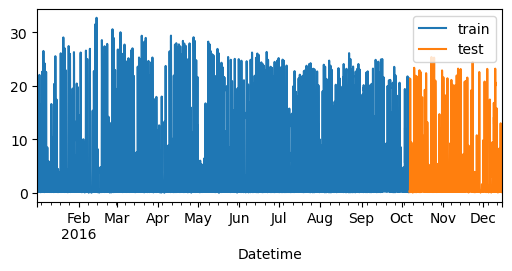

In [8]:
# https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/

# Split dataset into 80% training and 20% testing
split = round(len(hour_df)*.20)
data_train = hour_df[:-split]
data_test = hour_df[-split:]

# Check dataset lengths
print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

# Plot Datasets to vizualize and confirm split
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['Solar'].plot(ax=ax, label='train')
data_test['Solar'].plot(ax=ax, label='test')
ax.legend();

In [9]:
#reset the indices for cleanliness
data_train = data_train.reset_index()
data_test = data_test.reset_index()

# Duplicate the first row and add it to the training data - This will make it divisible by 24
prepend_data = data_train.iloc[0:1]
data_train = pd.concat([pd.DataFrame(prepend_data), data_train], ignore_index=True)
data_train['Datetime'][0:1] = '2016-01-01 00:00:00'
data_train.head()

,Datetime,Solar,temperature,visibility
0,2016-01-01 00:00:00,0.198417,2167.86,600.0
1,2016-01-01 01:00:00,0.198417,2167.86,600.0
2,2016-01-01 02:00:00,0.205300,2150.32,600.0
3,2016-01-01 03:00:00,0.206900,2123.10,600.0
4,2016-01-01 04:00:00,0.206850,2116.92,600.0


In [12]:
# Initial Variables used to build Test and Train Sequences
#   Sequence is 24-hours, Predictive Horizon is the next 6 hours
#   Features include Solar, Temperatuer, Visibility
seq_length = 24
ph = 1
pred_steps = 6
features = ['Solar', 'temperature', 'visibility']



In [13]:
# Build the sequence of TRAIN data and labels for predictions
train_seq = []
train_lab = []


# Create a Sequence List for TRAIN data (train_seq) and predictions (train_lab)
for i in range(0,len(data_train)-seq_length-pred_steps):
    
    # Build array of arrays
    train_seq.append(data_train[features].iloc[i:i + seq_length].to_numpy())
    
    # Calculate the start place for prediction (subtract 1 for zero-indexing)
    pred_start = (i + seq_length + ph-1)
    
    # Build array of predictions
    train_lab.append(data_train['Solar'].iloc[pred_start:pred_start+pred_steps].to_numpy())

        
# Convert lists to numpy arrays
train_seq = np.array(train_seq, dtype=object).astype(np.float32)
train_lab = np.array(train_lab, dtype=object).astype(np.float32)

print('Train Sequences Shape: ', train_seq.shape)
print('Train Labels Shape: ', train_lab.shape)

Train Sequences Shape:  (6690, 24, 3)
Train Labels Shape:  (6690, 6)


In [14]:
# Build the sequence of TEST data and labels for predictions
test_seq = []
test_lab = []

# Create a Sequence List for TEST data (test_seq) and predictions (test_lab)
for i in range(0,len(data_test)-seq_length-pred_steps):
    
    # Build array of arrays
    test_seq.append(data_test[features].iloc[i:i + seq_length].to_numpy())
    
    # Calculate the start place for prediction (subtract 1 for zero-indexing)
    pred_start = (i + seq_length + ph-1)
    
    # Build array of predictions
    test_lab.append(data_test['Solar'].iloc[pred_start:pred_start+pred_steps].to_numpy())

# Convert lists to numpy arrays
test_seq = np.array(test_seq, dtype=object).astype(np.float32)
test_lab = np.array(test_lab, dtype=object).astype(np.float32)

print('Test Sequences Shape: ', test_seq.shape)
print('Test Labels Shape: ', test_lab.shape)

Test Sequences Shape:  (1650, 24, 3)
Test Labels Shape:  (1650, 6)


In [ ]:
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    
    # define parameters
    verbose, epochs, batch_size = 0, 70, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
   
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model


def build_conv_model(train, n_steps, n_length, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    
    # define parameters
    verbose, epochs, batch_size = 0, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    
    # reshape into subsequences [samples, time steps, rows, cols, channels]
    train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
    
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    
    # define model
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model



In [16]:
# Build Base LSTM Model
model = build_base_model(train_seq, train_lab)


In [35]:
#Test Prediction with model
scores_test = model.evaluate(test_seq, test_lab, verbose=2)
y_pred_test = model.predict(test_seq)
y_true_test = test_lab


52/52 - 0s - loss: 36.6322 - 234ms/epoch - 5ms/step
52/52 [==============================] - 0s 4ms/step


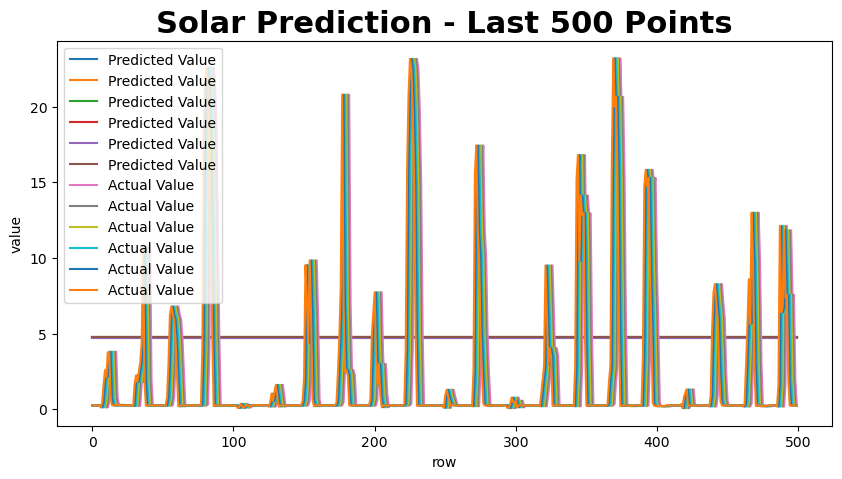

In [37]:

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Solar Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()

(24, 3)